In [1]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, make_scorer
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.set_index('OSEBuildingID', inplace = True)

In [4]:
data

,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,ENERGYSTARScore,EnergyStarNaN,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Age,PropertyGFAParking(%),PropertyGFABuilding(s)(%),SteamUse(%),Electricity(%),NaturalGas(%),PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,12.0,88434.0,88434.0,60.0,0.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,249.98,2.83,89.0,0.000000,100.000000,27.730162,54.605993,17.663838,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,11.0,103566.0,83880.0,61.0,0.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,295.86,2.86,20.0,14.545314,85.454686,0.000000,38.660907,61.339093,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,41.0,956110.0,756493.0,43.0,0.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,2089.28,2.19,47.0,20.574829,79.425171,29.711308,68.230741,2.057944,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.0,10.0,61320.0,61320.0,56.0,0.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,286.43,4.67,90.0,0.000000,100.000000,32.591344,40.751928,26.656717,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1.0,18.0,175580.0,123445.0,75.0,0.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,505.01,2.88,36.0,35.311539,64.688461,0.000000,37.880168,62.119825,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50222,1.0,1.0,12294.0,12294.0,46.0,0.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,20.94,1.70,26.0,0.000000,100.000000,0.000000,61.697384,38.302639,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50223,1.0,1.0,16000.0,16000.0,0.0,1.0,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,32.17,2.01,12.0,0.000000,100.000000,0.000000,41.729558,58.270426,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50224,1.0,1.0,13157.0,7583.0,0.0,1.0,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,223.54,16.99,42.0,0.000000,100.000000,0.000000,31.082041,68.917956,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
data.shape

(1648, 41)

In [6]:
"""data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]"""

'data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]'

In [7]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','LargestPropertyUseTypeGFA','ENERGYSTARScore','EnergyStarNaN',
        'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]


y = data['TotalGHGEmissions']

In [8]:
X.shape

(1648, 30)

In [9]:
y.head()

OSEBuildingID
1     249.98
2     295.86
3    2089.28
5     286.43
8     505.01
Name: TotalGHGEmissions, dtype: float64

In [10]:
std_scale = StandardScaler().fit(X)
X_scale = std_scale.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=7)

In [11]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_train, y_train)
baseline_error = mean_squared_error(y_test, dr.predict(y_test), squared=False)
baseline_error

968.2106104376774

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_error = mean_squared_error(y_test, lr.predict(X_test), squared=False)
lr_error

850.0826763557524

In [13]:
n_alphas = 100
alphas = np.logspace(-1, 7, n_alphas)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, mean_squared_error(y_test, ridge.predict(X_test), squared=False)])

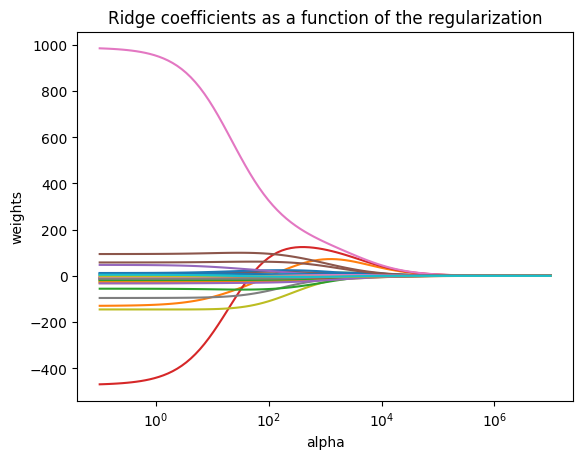

In [14]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

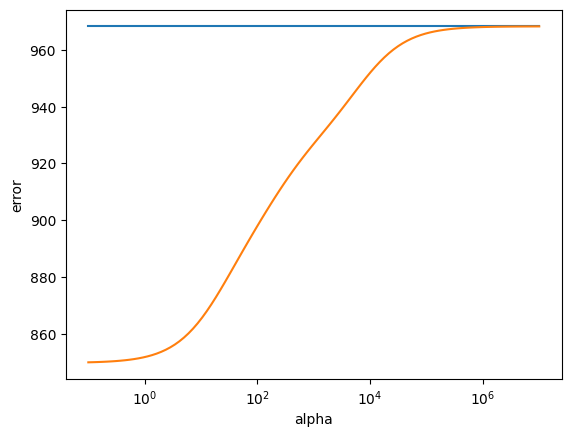

In [15]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [16]:
np.min(errors)

850.1049867455149

In [17]:
errors.index(min(errors))

0

In [18]:
errors[errors.index(min(errors))]

[968.2106104376774, 850.1049867455149]

In [19]:
alphas[errors.index(min(errors))]

0.1

In [20]:
ridge.set_params(alpha = alphas[errors.index(min(errors))])
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [21]:
mean_squared_error(y_test, ridge.predict(X_test), squared=False)

850.1049867455149

In [22]:
n_alphas = 100
alphas = np.logspace(-1, 4, n_alphas)
lasso = Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])

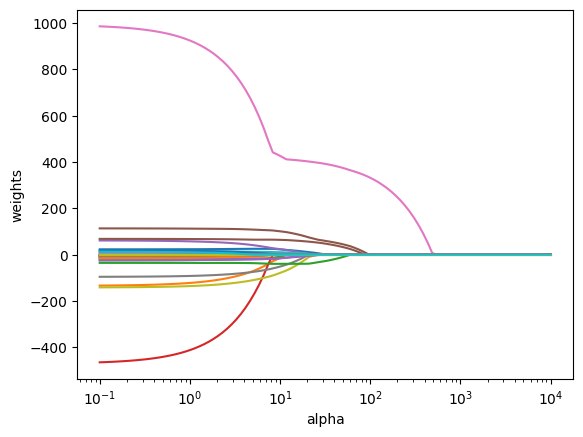

In [23]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

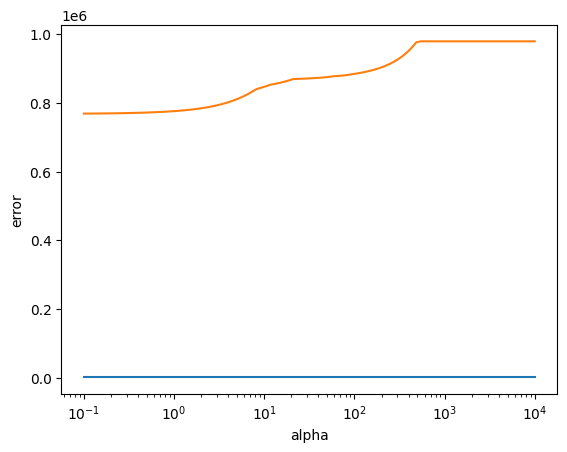

In [24]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [25]:
np.min(errors)

968.2106104376774

In [26]:
errors.index(min(errors))

0

In [27]:
alphas[errors.index(min(errors))]

0.1

In [28]:
lasso.set_params(alpha = alphas[errors.index(min(errors))])
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, fit_intercept=False)

In [29]:
mean_squared_error(y_test, lasso.predict(X_test), squared=False)

876.6981474251965

In [30]:
rmse_scorer = make_scorer(np.sqrt, greater_is_better=True)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=True)
msle_scorer = make_scorer(mean_squared_log_error, greater_is_better=True)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=True)

In [31]:
'''def resultize(grid): 
    results = pd.DataFrame(grid.cv_results_)
    results = results.sort_values(by='rank_test_rmse')
    results = results[['params', 'mean_test_rmse', 'mean_test_mse',
    'mean_test_msle', 'mean_test_mae']]
    results.columns = ['params', 'RMSE', 'MSE', 'MSLE', 'MAE']
    return results
'''

"def resultize(grid): \n    results = pd.DataFrame(grid.cv_results_)\n    results = results.sort_values(by='rank_test_rmse')\n    results = results[['param_alpha', 'mean_test_rmse', 'mean_test_mse',\n    'mean_test_msle', 'mean_test_mae']]\n    results.columns = ['alpha', 'RMSE', 'MSE', 'MSLE', 'MAE']\n    return results"

In [63]:
def resultize(grid, scoring):

    res = pd.DataFrame(grid.cv_results_)
    cols = [i for i in res.columns if "split" not in i]
    res = res[cols].sort_values(f'rank_test_{scoring}')
    res = res[['params', f'mean_test_{scoring}', f'rank_test_{scoring}']]
    res[f'mean_test_{scoring}'] = (-res[f'mean_test_{scoring}'])
    return res

In [33]:
def resultize_RMSE(grid): 
      results = pd.DataFrame(grid.cv_results_)
      results = results.sort_values(by = 'rank_test_score')
      results = results[['params', 'mean_test_score', 'rank_test_score']]
      results['mean_test_score'] = mean_squared_error(y_test, grid.predict(X_test), squared=False)
      return results

In [64]:
params = {'alpha': np.logspace(0, 7, 20)}
score = 'RMSE'
grid_ridge = GridSearchCV(Ridge(), params, cv = 10, 
                  scoring = s, refit = score, n_jobs=-1)
grid_ridge.fit(X_train, y_train)
grid_ridge_best_params = grid_ridge.best_params_
resultize(grid_ridge, score)

,params,mean_test_RMSE,rank_test_RMSE
8,{'alpha': 885.8667904100823},474.998050,1
9,{'alpha': 2069.138081114788},500.677169,2
7,{'alpha': 379.26901907322497},510.220872,3
10,{'alpha': 4832.930238571752},541.466565,4
6,{'alpha': 162.3776739188721},571.167998,5
11,{'alpha': 11288.378916846883},574.492680,6
12,{'alpha': 26366.508987303554},596.021928,7
13,{'alpha': 61584.82110660255},607.741769,8
14,{'alpha': 143844.9888287663},613.397635,9
15,{'alpha': 335981.8286283781},615.956236,10


In [67]:
res = pd.DataFrame(grid_ridge.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_RMSE,split1_test_RMSE,split2_test_RMSE,split3_test_RMSE,split4_test_RMSE,split5_test_RMSE,split6_test_RMSE,split7_test_RMSE,split8_test_RMSE,split9_test_RMSE,mean_test_RMSE,std_test_RMSE,rank_test_RMSE,split0_test_MSE,split1_test_MSE,split2_test_MSE,split3_test_MSE,split4_test_MSE,split5_test_MSE,split6_test_MSE,split7_test_MSE,split8_test_MSE,split9_test_MSE,mean_test_MSE,std_test_MSE,rank_test_MSE,split0_test_R2,split1_test_R2,split2_test_R2,split3_test_R2,split4_test_R2,split5_test_R2,split6_test_R2,split7_test_R2,split8_test_R2,split9_test_R2,mean_test_R2,std_test_R2,rank_test_R2
0,0.000881,0.000137,0.000499,0.000130,1.0,{'alpha': 1.0},-416.996754,-585.939800,-708.440968,-212.730729,-363.658363,-348.270464,-437.315181,-3058.793513,-284.884834,-872.111838,-728.914244,799.620874,20,-173886.292981,-343325.449802,-501888.605085,-45254.363150,-132247.405064,-121292.316381,-191244.567436,-9.356218e+06,-81159.368607,-760579.057575,-1.170710e+06,2.736587e+06,20,0.016380,0.371021,0.436174,-0.306000,0.083230,0.355744,0.447800,-7.371182,0.031748,0.391938,-0.554315,2.284122,20
1,0.000849,0.000151,0.000507,0.000139,2.335721,{'alpha': 2.3357214690901222},-416.922585,-586.769099,-710.970846,-211.945722,-359.289319,-345.586154,-441.031484,-3024.049998,-283.216642,-871.917293,-725.169914,789.820619,19,-173824.441881,-344297.975104,-505479.543337,-44920.989103,-129088.814710,-119429.789634,-194508.769815,-9.144878e+06,-80211.666473,-760239.766305,-1.149688e+06,2.673395e+06,19,0.016730,0.369239,0.432140,-0.296379,0.105126,0.365637,0.438375,-7.182093,0.043055,0.392209,-0.531596,2.228459,19
2,0.000817,0.000131,0.000461,0.000121,5.455595,{'alpha': 5.455594781168519},-416.859009,-588.523877,-715.968651,-210.724578,-351.836324,-341.594089,-448.753964,-2947.856171,-280.123495,-871.925683,-717.416584,768.161260,18,-173771.433358,-346360.354356,-512611.109447,-44404.847831,-123788.799079,-116686.521379,-201380.120259,-8.689856e+06,-78469.172590,-760254.396301,-1.104758e+06,2.537267e+06,18,0.017030,0.365461,0.424128,-0.281483,0.141867,0.380208,0.418534,-6.774976,0.063843,0.392198,-0.485319,2.107977,18
3,0.000915,0.000139,0.000535,0.000133,12.74275,{'alpha': 12.742749857031335},-416.703526,-591.807454,-724.365513,-209.416953,-342.285727,-338.163013,-462.120193,-2790.695473,-275.440783,-873.104847,-702.410348,723.178091,17,-173641.828822,-350236.062553,-524705.396407,-43855.460147,-117159.519175,-114354.223206,-213555.072383,-7.787981e+06,-75867.624939,-762312.073065,-1.016367e+06,2.267421e+06,17,0.017763,0.358360,0.410542,-0.265629,0.187823,0.392596,0.383380,-5.968052,0.094880,0.390553,-0.399778,1.867757,17
4,0.000735,0.000175,0.000471,0.000134,29.763514,{'alpha': 29.76351441631318},-415.172775,-596.848101,-735.630110,-208.110449,-333.501890,-338.000585,-478.994462,-2497.768423,-269.814945,-877.121727,-675.096347,639.640544,16,-172368.432695,-356227.655829,-541151.659104,-43309.958871,-111223.510734,-114244.395258,-229435.695100,-6.238847e+06,-72800.104750,-769342.524366,-8.648951e+05,1.804698e+06,16,0.024966,0.347384,0.392066,-0.249886,0.228972,0.393180,0.337526,-4.582012,0.131476,0.384932,-0.259140,1.454206,16


In [69]:
cols = [col for col in res.columns if 'mean_test' in col]
cols

['mean_test_RMSE', 'mean_test_MSE', 'mean_test_R2']

In [35]:
grid_rf_best_params = {'alpha': 10000000.0}

In [36]:
rf = Ridge(**grid_rf_best_params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_error = mean_squared_error(y_test, y_pred, squared=False)
rf_error

968.1845301165456

In [37]:
params = {"alpha": np.logspace(-1, 3, 30)}
grid_lasso = GridSearchCV(Lasso(), params, cv = 10)
grid_lasso.fit(X_train, y_train)
grid_lasso_best_params = grid_lasso.best_params_
resultize_RMSE(grid_lasso).head()

,params,mean_test_score,rank_test_score
21,{'alpha': 78.80462815669912},913.531584,1
22,{'alpha': 108.2636733874054},913.531584,2
20,{'alpha': 57.361525104486816},913.531584,3
23,{'alpha': 148.73521072935117},913.531584,4
24,{'alpha': 204.33597178569417},913.531584,5


In [38]:
grid_lasso_best_params = {'alpha': 727.8953843983146}	

In [39]:
lasso = Lasso(**grid_lasso_best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso_error = mean_squared_error(y_test, y_pred, squared=False)
lasso_error

968.2106104376774

In [40]:
tt_ridge = TransformedTargetRegressor(regressor = Ridge(),
                               func = np.log1p,
                               inverse_func = np.expm1)
tt_ridge.fit(X_train, y_train)
y_pred = tt_ridge.predict(X_test)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

953.49932095739

In [41]:
params = {'regressor__alpha': np.logspace(0, 7, 100)}
grid_tt_ridge = GridSearchCV(tt_ridge, params, cv = 10)
grid_tt_ridge.fit(X_train, y_train)
grid_tt_ridge_best_params = grid_tt_ridge.best_params_
resultize_RMSE(grid_tt_ridge).head()

,params,mean_test_score,rank_test_score
53,{'regressor__alpha': 5590.810182512223},976.585762,1
52,{'regressor__alpha': 4750.810162102794},976.585762,2
54,{'regressor__alpha': 6579.3322465756755},976.585762,3
55,{'regressor__alpha': 7742.63682681127},976.585762,4
56,{'regressor__alpha': 9111.627561154886},976.585762,5


In [42]:
grid_tt_ridge_best_params = {'alpha': 10000000.0}

In [43]:
tt_ridge = TransformedTargetRegressor(regressor = Ridge(**grid_tt_ridge_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ridge.fit(X_train, y_train)
y_pred = tt_ridge.predict(X_test)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

979.7336451970851

In [44]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

977.5383669115446

In [52]:
params = {'kernel': ['sigmoid','rbf','poly'],
         'C': [0.1,1,100,1000],
         'degree': [1,2,3,4,5,6]}
s = {"RMSE": "neg_root_mean_squared_error", "MSE": "neg_mean_squared_error", "R2":"r2"}
grid_svr = GridSearchCV(SVR(), params, cv=10,scoring = s, refit = "RMSE",  n_jobs=-1)
grid_svr.fit(X_train, y_train)
best_params_svr = grid_svr.best_params_
resultize(grid_svr).head()

KeyError: 'rank_test_score'

In [ ]:
'''params = {'kernel': ['sigmoid','rbf','poly','sigmoid'],
         'C': [0.1,1,100,1000],
         'degree': [1,2,3,4,5,6]}
grid = GridSearchCV(SVR(), params, cv=10)
grid.fit(X_train, y_train)
best_params_svr = grid.best_params_
resultize(grid).head()'''

In [47]:
best_params_svr = {'C': 1000, 'degree': 6, 'kernel': 'rbf'}

In [48]:
svr = SVR(**best_params_svr)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

916.5661190492019

In [49]:
tt = TransformedTargetRegressor(regressor = SVR(**best_params_svr),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt.fit(X_train, y_train)
y_pred = tt.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

2720.748165944485

In [ ]:
'''tt = TransformedTargetRegressor(regressor = SVR(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__C': [0.1,1,100,1000],
            'regressor__degree': [1,2,3,4,5,6],
            'regressor__kernel': ['sigmoid','rbf','poly']}
grid = GridSearchCV(tt, params, cv = 10)
grid.fit(X_train, y_train)
best_params_svr_tt = grid.best_params_
resultize(grid).head()'''

In [ ]:
'''tt = TransformedTargetRegressor(regressor = SVR(**best_params_svr_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt.fit(X_train, y_train)
y_pred = tt.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)'''

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
"""params = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [1,2,3,4,5,6,7,8,9,10],
            'min_samples_split': [2,3,4,5,6,7,8,9,10],
}
grid = GridSearchCV(RandomForestRegressor(), params, cv=10)
grid.fit(X_train, y_train)
best_params_rf = grid.best_params_
resultize(grid).head()"""

In [ ]:
best_params_rf ={'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

In [ ]:
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
tt = TransformedTargetRegressor(regressor = RandomForestRegressor(**best_params_rf),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt.fit(X_train, y_train)
y_pred = tt.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
'''tt_rf = TransformedTargetRegressor(regressor = RandomForestRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__max_depth': [1,2,3,4,5,6,7,8,9,10],
            'regressor__min_samples_split': [2,3,4,5,6,7,8,9,10]}
grid = GridSearchCV(tt_rf, params, cv = 10)
grid.fit(X_train, y_train)
best_params_rf_tt = grid.best_params_
resultize(grid).head()'''

In [ ]:
best_params_rf_tt = {'max_depth': 10,
 'min_samples_split': 4,
 'n_estimators': 200}
rf_tt = TransformedTargetRegressor(
      regressor = RandomForestRegressor(**best_params_rf_tt),
      func = np.log1p,
      inverse_func = np.expm1)
rf_tt.fit(X_train, y_train)
y_pred = rf_tt.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
'''params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [4, 6],
            'min_samples_leaf': [3, 5, 9, 17],
}
grid = GridSearchCV(GradientBoostingRegressor(), params, cv=10)
grid.fit(X_train, y_train)
best_params_gb = grid.best_params_
resultize(grid).head()'''

In [ ]:
best_params_gb = {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 9}

In [ ]:
gb = GradientBoostingRegressor(**best_params_gb)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
'''tt_gb = TransformedTargetRegressor(regressor = GradientBoostingRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [4, 6],
            'regressor__min_samples_leaf': [3, 5, 9, 17]}
grid = GridSearchCV(tt_gb, params, cv = 10)
grid.fit(X_train, y_train)
best_params_gb_tt = grid.best_params_
resultize(grid).head()'''

In [ ]:
best_params_gb_tt = {'learning_rate': 0.1,
      'loss': 'ls',
      'max_depth': 6,
      'min_samples_leaf': 5
      }
gb_tt = TransformedTargetRegressor(regressor=GradientBoostingRegressor(**best_params_gb_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
gb_tt.fit(X_train, y_train)
y_pred = gb_tt.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
ad =  AdaBoostRegressor()
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
'''params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'loss': ['linear', 'square', 'exponential'],
}
grid = GridSearchCV(AdaBoostRegressor(), params, cv=10)
grid.fit(X_train, y_train)
best_params_ad = grid.best_params_
resultize(grid).head()'''

In [ ]:
best_params_ad = {'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 400}

In [ ]:
ad = AdaBoostRegressor(**best_params_ad)
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
"""tt_ad = TransformedTargetRegressor(regressor = AdaBoostRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__loss': ['linear', 'square', 'exponential'],
}
grid = GridSearchCV(tt_ad, params, cv = 10)
grid.fit(X_train, y_train)
best_params_ad_tt = grid.best_params_
resultize(grid).head()"""

In [ ]:
best_params_ad_tt = {'learning_rate': 0.1,
      'loss': 'square',
      'n_estimators': 200
      }
tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(**best_params_ad_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_ad.fit(X_train, y_train)
y_pred = tt_ad.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
'''params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
}
grid = GridSearchCV(MLPRegressor(), params, cv=10)
grid.fit(X_train, y_train)
best_params_mlp = grid.best_params_
resultize(grid).head()'''

In [ ]:
best_params_mlp = {'activation': 'logistic',
                  'hidden_layer_sizes': (200,), 
                  'solver': 'lbfgs'}

In [ ]:
mlp = MLPRegressor(**best_params_mlp)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
"""tt_mlp = TransformedTargetRegressor(regressor = MLPRegressor(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'regressor__solver': ['lbfgs', 'adam'],
}
grid = GridSearchCV(tt_mlp, params, cv = 10)
grid.fit(X_train, y_train)
best_params_mlp_tt = grid.best_params_
resultize(grid).head()"""

In [ ]:
best_params_mlp_tt = {'activation': 'tanh',
      'hidden_layer_sizes': (100,),
      'solver': 'adam'
      }
tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(**best_params_mlp_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_mlp.fit(X_train, y_train)
y_pred = tt_mlp.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)